This note book shows parameter tuning with Light GBM and Optuna.Sometime parameter tuning takes a long time even through Optuna.  
Optuna have an API for tuning completion within limited time.

### 1. Import Libraries 

In [1]:
import time
import numpy as np
import pandas as pd

from IPython.display import display

import optuna
import lightgbm as lgb
import optuna.integration.lightgbm as lgb_op
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn import metrics

from collections import Counter

## 2. Setting for dataset

In [2]:
# file path(train data and test data)
train_path = '../input/tabular-playground-series-may-2021/train.csv'
test_path = '../input/tabular-playground-series-may-2021/test.csv'

In [3]:
# column name for submission file
ID_column = 'id'

# column name of the target data
target = 'target'
submission_cols = ['Class_1', 'Class_2', 'Class_3', 'Class4']

In [4]:
# read csv file
dtrain = pd.read_csv(train_path, header=0)
dtest = pd.read_csv(test_path, header=0)

# To drop reject items columns from train data set
X = pd.DataFrame(dtrain).drop(columns=[ID_column, target], axis=1)
y = pd.Series(dtrain[target])

# ID of test.csv for submission
ID_s = dtest.iloc[:,[0]]    # row 0 : ID

# Target data(Test data)
X_s = pd.DataFrame(dtest).drop(columns=[ID_column], axis=1)

# replace target value as below
dic={"Class_1":0, "Class_2":1, "Class_3":2, "Class_4":3}
y.replace(dic, inplace=True)

In [5]:
# check the shape
print('X shape: (%i,%i)' %X.shape)
print('y shape: (%i,)' %y.shape)

print(y.value_counts())
X.join(y).head()

X shape: (100000,50)
y shape: (100000,)
1    57497
2    21420
3    12593
0     8490
Name: target, dtype: int64


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,1,0,1,0,0,0,0,0,...,0,0,21,0,0,0,0,0,0,1
1,0,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,2,...,0,1,0,0,0,0,13,2,0,0
3,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,1,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [6]:
# check the shape
print('X_s shape: (%i,%i)' %X_s.shape)
X_s.head()

X_s shape: (50000,50)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,0,0,0,0,0,4,4,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,2,0,7,7,...,3,0,1,0,0,0,1,0,2,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,6,0
3,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,6,9,14,3
4,0,0,0,0,0,0,1,0,4,0,...,1,0,0,0,0,0,0,0,0,0


In [7]:
# Missing Value Check
X.isnull().sum()

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
feature_30    0
feature_31    0
feature_32    0
feature_33    0
feature_34    0
feature_35    0
feature_36    0
feature_37    0
feature_38    0
feature_39    0
feature_40    0
feature_41    0
feature_42    0
feature_43    0
feature_44    0
feature_45    0
feature_46    0
feature_47    0
feature_48    0
feature_49    0
dtype: int64

In [8]:
# Missing Value Check
X_s.isnull().sum()

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
feature_30    0
feature_31    0
feature_32    0
feature_33    0
feature_34    0
feature_35    0
feature_36    0
feature_37    0
feature_38    0
feature_39    0
feature_40    0
feature_41    0
feature_42    0
feature_43    0
feature_44    0
feature_45    0
feature_46    0
feature_47    0
feature_48    0
feature_49    0
dtype: int64

<AxesSubplot:>

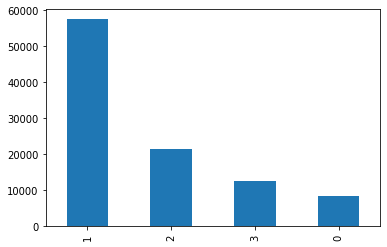

In [9]:
y.value_counts().plot(kind='bar')

In [10]:
# Random / SMOTE  undersampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_under, y_under = rus.fit_resample(X, y)
Counter(y_under)

Counter({0: 8490, 1: 8490, 2: 8490, 3: 8490})

In [11]:
# Random / SMOTE  oversampling
from imblearn.over_sampling import RandomOverSampler,SMOTE

ros = RandomOverSampler(random_state=46)
smt = SMOTE(random_state=46)

X_over,y_over = ros.fit_resample(X, y)
X_smt,y_smt = smt.fit_resample(X, y)

print('Random Over Sampler',Counter(y_over))
print('SMOTE', Counter(y_smt))

Random Over Sampler Counter({1: 57497, 0: 57497, 3: 57497, 2: 57497})
SMOTE Counter({1: 57497, 0: 57497, 3: 57497, 2: 57497})


<AxesSubplot:>

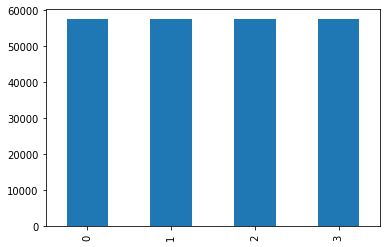

In [12]:
y_smt.value_counts().plot(kind='bar')

### 3.Define objective function
#### 3-1. Objective function

In [13]:
class Objective_lgb:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __call__(self, trial):
        # Special method when the object is called
        lgbm_params = {'objective': 'multiclass',
                       'metric': 'multi_logloss',
                       'max_depth' : trial.suggest_int('max_depth', 1, 10),
                       'subsumple' : trial.suggest_uniform('subsumple', 0.0, 1.0),
                       'subsample_freq' : trial.suggest_int('subsample_freq', 0, 1),
                       'leaning_rate' : trial.suggest_loguniform('leaning_rate', 1e-5, 1),
                       'feature_fraction' : trial.suggest_uniform('feature_fraction', 0.0, 1.0),
                       'lambda_l1' : trial.suggest_uniform('lambda_l1' , 0.0, 1.0),
                       'lambda_l2' : trial.suggest_uniform('lambda_l2' , 0.0, 1.0),
                       'num_class': 4,
                      }
        
        model = lgb.LGBMClassifier(**lgbm_params)
        
        # Stratified Cross Validation
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=46)
        scores = cross_validate(model,
                                 X=self.X, y = self.y,
                                 cv=kf,
                                 scoring = 'neg_log_loss',
                                 n_jobs=-1)                         
        
        
        return scores['test_score'].mean()

#### 3-2.Parameter Tuning with optuna  
Optimization takes long time to finish.
If I do not have enough time or prefer to execute pre-experiment , I want to finish within expected time before training for modeling.
In this case, "timeout" setting can limit time.
Within limit time, parameter tuning will finish. But the parameter may not be best.

In [14]:
evaluation_results={}
# objective = Objective_lgb(X, y)
objective = Objective_lgb(X, y)

# Define optimization of objective Minimanization 
study = optuna.create_study(direction = 'minimize')

# Define time limit, not trial number
study.optimize(objective, timeout=10800) #second,  timeout is parameter to limit tuning time,  (1800s, 30min)
print('params:', study.best_params)

[I 2021-05-30 16:15:45,743] A new study created in memory with name: no-name-e327921f-d420-483e-aff0-01e9f597f28a
[I 2021-05-30 16:16:04,760] Trial 0 finished with value: -1.0947384900463681 and parameters: {'max_depth': 4, 'subsumple': 0.27143843993753225, 'subsample_freq': 1, 'leaning_rate': 0.000338443342424311, 'feature_fraction': 0.3684308456439991, 'lambda_l1': 0.8148195649168418, 'lambda_l2': 0.4207438205795212}. Best is trial 0 with value: -1.0947384900463681.
[I 2021-05-30 16:16:11,531] Trial 1 finished with value: -1.1072021454888072 and parameters: {'max_depth': 3, 'subsumple': 0.8016536051675754, 'subsample_freq': 1, 'leaning_rate': 0.0008237132413905996, 'feature_fraction': 0.029744181272078563, 'lambda_l1': 0.036283469746995145, 'lambda_l2': 0.4559853045683937}. Best is trial 1 with value: -1.1072021454888072.
[I 2021-05-30 16:16:31,753] Trial 2 finished with value: -1.0943050770943707 and parameters: {'max_depth': 10, 'subsumple': 0.5545923431045056, 'subsample_freq': 0,

params: {'max_depth': 1, 'subsumple': 0.758104541519137, 'subsample_freq': 1, 'leaning_rate': 0.26011588430995947, 'feature_fraction': 0.0001557803567947217, 'lambda_l1': 0.869562523611517, 'lambda_l2': 0.8582312584921781}


#### 3-3. Check best parameter

In [15]:
print('[Best Score trial]')
print('-'*50)
trial = study.best_trial
print('Value:{}'.format(trial.value))
print('Params:')
for k, v in study.best_params.items():
    print(f'{k} : {v}')

[Best Score trial]
--------------------------------------------------
Value:-1.109585435490527
Params:
max_depth : 1
subsumple : 0.758104541519137
subsample_freq : 1
leaning_rate : 0.26011588430995947
feature_fraction : 0.0001557803567947217
lambda_l1 : 0.869562523611517
lambda_l2 : 0.8582312584921781


### 4. Training with best parameter

In [16]:
model = lgb.LGBMClassifier(**study.best_params)
model.fit(X,y)

[LightGBM] [Warning] Unknown parameter: leaning_rate
[LightGBM] [Warning] Unknown parameter: subsumple
[LightGBM] [Warning] lambda_l1 is set=0.869562523611517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.869562523611517
[LightGBM] [Warning] lambda_l2 is set=0.8582312584921781, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8582312584921781
[LightGBM] [Warning] feature_fraction is set=0.0001557803567947217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.0001557803567947217


LGBMClassifier(feature_fraction=0.0001557803567947217,
               lambda_l1=0.869562523611517, lambda_l2=0.8582312584921781,
               leaning_rate=0.26011588430995947, max_depth=1, subsample_freq=1,
               subsumple=0.758104541519137)

### 5. Evaluation  
#### 5-1. Accuracy

In [17]:
# Evaluation
y_pred = model.predict(X)

# Accuracy calculation
accuracy = sum(y == y_pred) / len(y)
print('accuracy:', accuracy)

accuracy: 0.57505


#### 5-4. Confusion Matrix

In [18]:
from sklearn.metrics import confusion_matrix

eval_cmx = confusion_matrix(y, y_pred)

# DataFrame
eval_cmx_df = pd.DataFrame(eval_cmx, columns=submission_cols, index=submission_cols)

print('Confution matrix with train all pics data')

# 結果の表示
eval_cmx_df

Confution matrix with train all pics data


,Class_1,Class_2,Class_3,Class4
Class_1,0,8489,1,0
Class_2,0,57492,5,0
Class_3,0,21407,13,0
Class4,0,12591,2,0


### 6.Test data prediction

In [19]:
# Evaluation
y_pred_proba = model.predict_proba(X_s)
y_pred_proba

array([[0.0848509 , 0.59584844, 0.2014259 , 0.11787476],
       [0.08308709, 0.61332385, 0.18745607, 0.11613299],
       [0.08744131, 0.57358377, 0.21619758, 0.12277735],
       ...,
       [0.08397441, 0.55064062, 0.23111482, 0.13427015],
       [0.08622337, 0.57762399, 0.19829816, 0.13785448],
       [0.08529926, 0.57355856, 0.21202416, 0.12911802]])

### 7. Submission

In [20]:
# id DataFrame
id_df=pd.DataFrame(data=ID_s,columns=[ID_column])

# prediction result DataFrame
submission_column_list =  ['Class_1','Class_2', 'Class_3', 'Class_4']
result_df = pd.DataFrame(data=y_pred_proba, columns=submission_column_list)

submit_df = pd.concat([id_df, result_df], axis=1)
submit_df.head()

# To generate csv file for submittion
submit_df.to_csv('submission.csv', index=False)